# k-Means Clustering

In [1]:
import math, matplotlib.pyplot as plt, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create Data

In [3]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

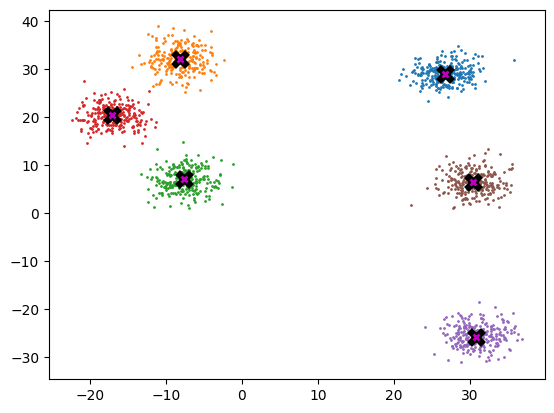

In [9]:
plot_data(centroids, data, n_samples)

# k-Means

From [Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm_(naive_k-means)):

**Standard algorithm (naive ***k***-means)**

Given an initial set of *k* means $m_1^{(1)}, ..., m_k^{(1)}$, the algorithm proceeds by alternating between two steps:

1. **Assignment step**: Assign each observation to the cluster with the nearest mean (Euclidean distance).
2. **Update step**: Recalculate means for observations assigned to each cluster.

In [10]:
n = len(data)
idx = torch.randperm(n)[:n_clusters]
idx

tensor([644, 150,  64, 681, 797, 756])

We initialise the means using the Forgy method (randomly chosen observations).

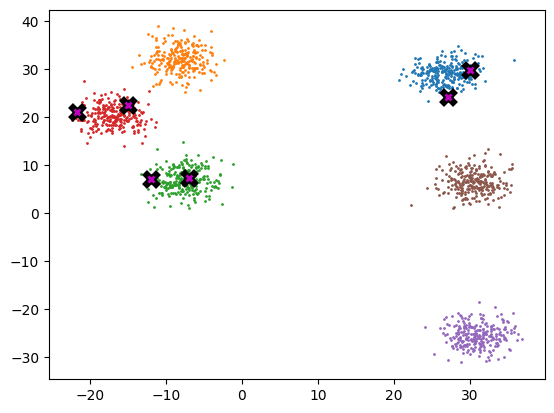

In [11]:
means = data[idx]
plot_data(means, data, n_samples)

In [12]:
x = data[0]
x

tensor([26.204, 26.349])

In [13]:
means

tensor([[-11.982,   7.141],
        [ 27.161,  24.295],
        [ 30.069,  29.822],
        [ -6.934,   7.395],
        [-21.721,  21.167],
        [-15.015,  22.542]])

In [14]:
x.shape, means.shape

(torch.Size([2]), torch.Size([6, 2]))

In [15]:
dist = ((x-means)**2).sum(1).sqrt()
dist

tensor([42.745,  2.266,  5.197, 38.175, 48.204, 41.394])

In [16]:
dist = torch.einsum('ij,ij->i', x-means, x-means).sqrt()
dist

tensor([42.745,  2.266,  5.197, 38.175, 48.204, 41.394])

In [17]:
closest_cluster = dist.argmin()
closest_cluster

tensor(1)

In [18]:
def one_update(data, means):
    clusters = [[] for n in range(len(means))]
    for i, x in enumerate(data):
        dist = torch.einsum('ij,ij->i', x-means, x-means).sqrt()
        # dist = ((x-means)**2).sum(1).sqrt() # same thing but boring
        closest_cluster = dist.argmin()
        clusters[closest_cluster].append(i)    
    return clusters

In [19]:
clusters = one_update(data, means)

In [20]:
list(map(len, clusters))

[59, 466, 167, 310, 79, 419]

In [21]:
data[clusters[0]].mean(0)

tensor([-10.658,   6.614])

In [22]:
def k_means(data, n_clusters, max_iter=200):
    n = len(data)
    means = data[torch.randperm(n)[:n_clusters]]
    for it in range(max_iter):
        clusters = one_update(data, means)
        for j in range(n_clusters):
            means[j] = data[clusters[j]].mean(0)
    return means

In [23]:
%time means = k_means(data, n_clusters)

CPU times: user 6.25 s, sys: 0 ns, total: 6.25 s
Wall time: 6.24 s


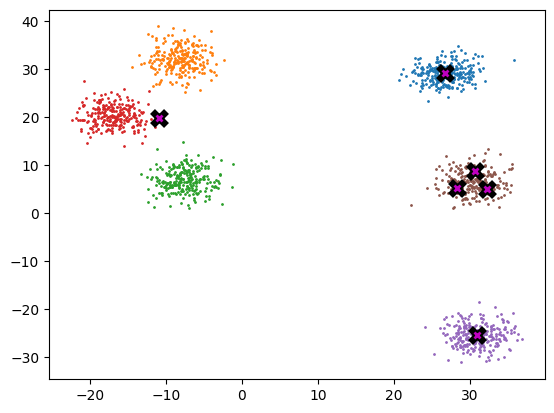

In [24]:
plot_data(means, data, n_samples)

# Animation

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [26]:
def do_one(d):
    if d:
        clusters = one_update(data, means)
        for j in range(n_clusters):
            means[j] = data[clusters[j]].mean(0)
    ax.clear()
    plot_data(means, data, n_samples, ax=ax)

In [27]:
fig,ax = plt.subplots()
n = len(data)
means = data[torch.randperm(n)[:n_clusters]]
ani = FuncAnimation(fig, do_one, frames=20, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

# GPU Accelerated Algorithm

In [28]:
x = data[0]
x

tensor([26.204, 26.349])

In [29]:
n = len(data)
means = data[torch.randperm(n)[:n_clusters]]
means

tensor([[-16.785,  20.127],
        [ 24.958,  30.204],
        [ 30.822, -23.313],
        [-16.887,  23.348],
        [ 30.490,   6.584],
        [ -8.443,  31.215]])

In [30]:
dist = torch.einsum('ij,ij->i', x-means, x-means).sqrt()
dist

tensor([43.437,  4.051, 49.876, 43.195, 20.224, 34.986])

In [31]:
x = data[:5]
x

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        [25.647, 30.033],
        [31.236, 30.093]])

In [32]:
x.shape, means.shape

(torch.Size([5, 2]), torch.Size([6, 2]))

In [33]:
x[:, None, :].shape, (x[:, None, :]-means).shape

(torch.Size([5, 1, 2]), torch.Size([5, 6, 2]))

In [34]:
dist = ((x[:, None, :]-means)**2).sum(2).sqrt()
dist

tensor([[43.437,  4.051, 49.876, 43.195, 20.224, 34.986],
        [43.657,  0.732, 53.772, 43.128, 24.111, 34.148],
        [47.987,  5.677, 52.008, 47.620, 22.109, 38.956],
        [43.573,  0.709, 53.597, 43.056, 23.944, 34.110],
        [49.045,  6.279, 53.408, 48.594, 23.521, 39.695]])

In [35]:
closest_mean = dist.argmin(1)
closest_mean

tensor([1, 1, 1, 1, 1])

In [36]:
def k_means(data, n_clusters, bs=512, max_iter=200):
    n = len(data)
    means = data[torch.randperm(n)[:n_clusters]]
    closest_mean = torch.empty(n)
    for it in range(max_iter):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            dist = ((data[s, None, :]-means)**2).sum(2).sqrt()
            closest_mean[s] = dist.argmin(1)
        for i in range(n_clusters):
            means[i] = data[(closest_mean == i).argwhere()].mean(0)
    return means

In [37]:
data_on_gpu = data.cuda()
data_on_gpu.get_device(), data.get_device()

(0, -1)

In [38]:
%time means = k_means(data_on_gpu, n_clusters, bs=len(data)).cpu()

CPU times: user 123 ms, sys: 45.9 ms, total: 169 ms
Wall time: 168 ms


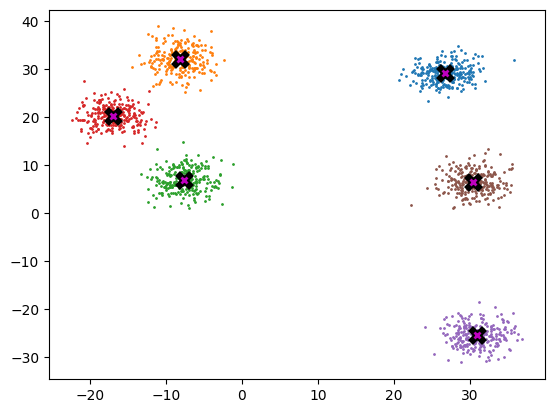

In [39]:
plot_data(means, data, n_samples)

The GPU accelerated algorithm runs in 168 ms, while the algorithm on CPU takes 6.24 seconds to run, a speedup of about 37 times!